In [6]:
from GT import get_dataset, denormalize
import matplotlib.pyplot as plt
from GT import GTM
from GT import gmm_loss
import json
import torch
from MMD import mmd_poly, mmd_linear, mmd_rbf
import numpy as np
import os
from tsl.datasets import AirQuality, MetrLA, PemsBay

DATASET_NAME = 'MetrLA'
MODEL_NAME= 'GMM'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [7]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [8]:
# Model Parameters 100 hidden
hidden_size = 128
num_layers = 1
lr = 0.001
weight_decay = 0.001
# weight_decay = 0
dropout = 0
bidirectional = True
mixture_dim = 32
debug = False
train_from_checkpoint = False
dataset = MetrLA()


## Dataset

In [9]:
dataset = dataset.dataframe()[-10000:]

In [16]:
dataset

nodes,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
channels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-05-24 06:40:00,65.000000,60.888889,48.777779,54.111111,58.555557,55.555557,65.777779,63.333332,53.888889,22.333334,...,47.000000,67.777779,59.555557,65.888885,68.111115,63.777779,66.333336,52.111111,68.222221,53.111111
2012-05-24 06:45:00,68.222221,63.222221,31.444445,52.555557,38.333332,55.888889,67.888885,62.222221,46.000000,18.888889,...,47.888889,66.555557,64.222221,66.111115,67.000000,64.000000,68.333336,51.000000,67.444443,53.333332
2012-05-24 06:50:00,66.555557,64.444443,37.777779,52.444443,47.222221,52.666668,65.333336,64.333336,21.555555,12.666667,...,46.777779,67.666664,63.444443,66.888885,66.777779,65.333336,68.555557,52.222221,66.222221,57.444443
2012-05-24 06:55:00,67.000000,63.250000,42.250000,52.625000,37.125000,51.000000,67.428574,64.750000,21.750000,18.875000,...,47.375000,66.375000,64.125000,65.500000,66.750000,65.125000,69.250000,50.500000,64.750000,54.500000
2012-05-24 07:00:00,66.222221,64.333336,44.333332,52.444443,38.222221,50.888889,66.111115,61.555557,33.888889,11.500000,...,45.111111,67.000000,62.000000,65.888885,66.222221,64.777779,68.777779,44.111111,64.888885,50.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-27 23:35:00,65.000000,65.888885,68.555557,61.666668,32.833332,54.555557,62.444443,63.333332,59.222221,65.333336,...,52.888889,69.000000,65.111115,55.666668,66.333336,62.444443,66.777779,64.888885,69.666664,62.333332
2012-06-27 23:40:00,61.375000,65.625000,66.500000,62.750000,32.833332,50.500000,62.000000,67.000000,65.250000,67.125000,...,54.000000,69.250000,60.125000,60.500000,67.250000,59.375000,66.000000,61.250000,69.000000,62.000000
2012-06-27 23:45:00,67.000000,59.666668,69.555557,61.000000,32.833332,44.777779,64.222221,63.777779,59.777779,57.666668,...,51.333332,67.888885,64.333336,57.000000,66.000000,62.666668,68.666664,63.333332,67.444443,61.222221


In [10]:
# Dataset Split\
Train, Validation, Test = get_dataset('MetrLA', dataset=dataset)

train_data = Train
train_data = torch.Tensor(train_data)
train_label = train_data
train_data = train_data[:-1]
train_label = train_label[1:]

validation_data = Validation
validation_data = torch.Tensor(validation_data)
validation_label = validation_data
validation_data = validation_data[:-1]
validation_label = validation_label[1:]

input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)

MetrLA DATA
________________________________________
Original Dataset: 	10000
Train Split: 		7000 	(70%)
Validation Split: 	2000 	(20%)
Test Split: 		1000 	(10%)
________________________________________


## Model Train

In [11]:
# Model Train
model = GTM(input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, gmm_loss, lr, weight_decay, ['EarlyStopping'], DEVICE, debug)

configs = input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, debug
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, train_label, 2, 10)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

Model not present or incompatible
Starting training...


Loss -2.439143987956276: 100%|██████████| 6999/6999 [14:06<00:00,  8.26it/s] 


Epoch 1 - loss: -2.4374960075847243


Loss -2.4487143868823984: 100%|██████████| 6999/6999 [14:08<00:00,  8.25it/s]

Epoch 2 - loss: -2.4469833742700233


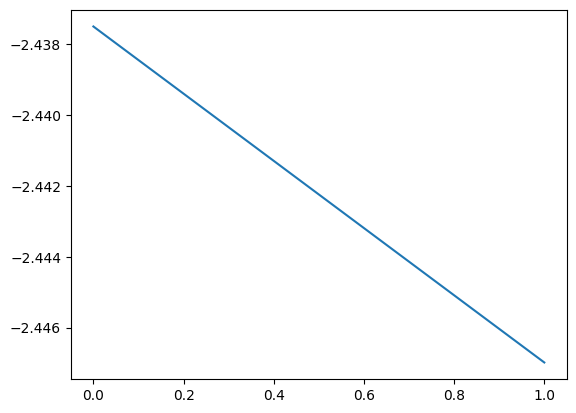

<Figure size 640x480 with 0 Axes>

In [12]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

## Predict on Train

100%|██████████| 75/75 [00:00<00:00, 93.29it/s]


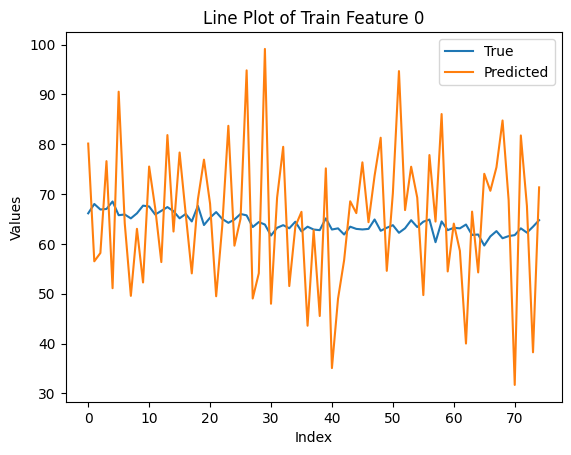

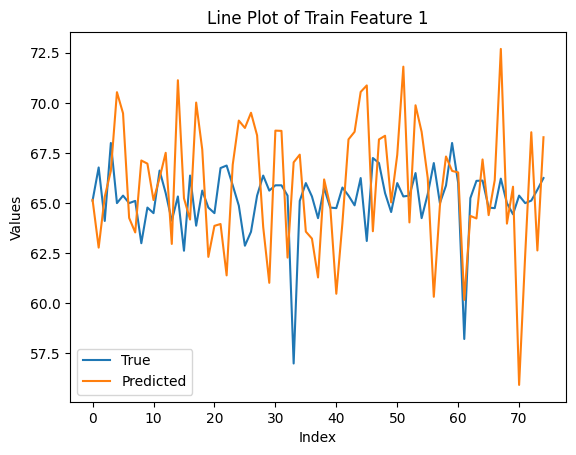

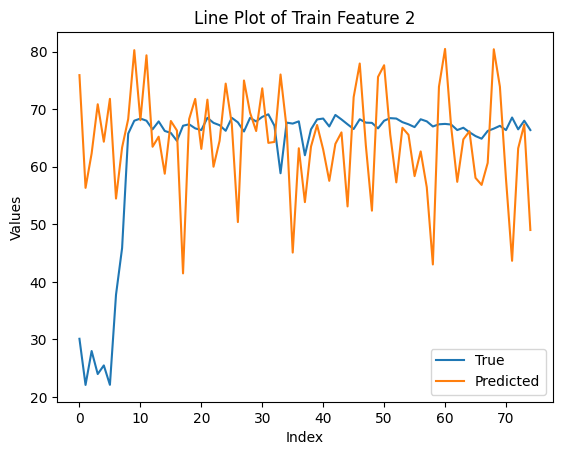

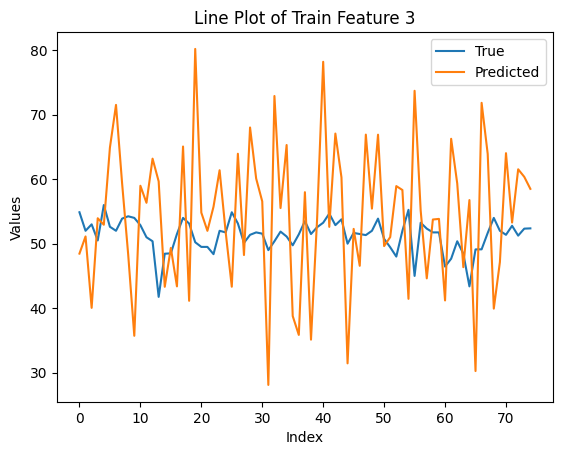

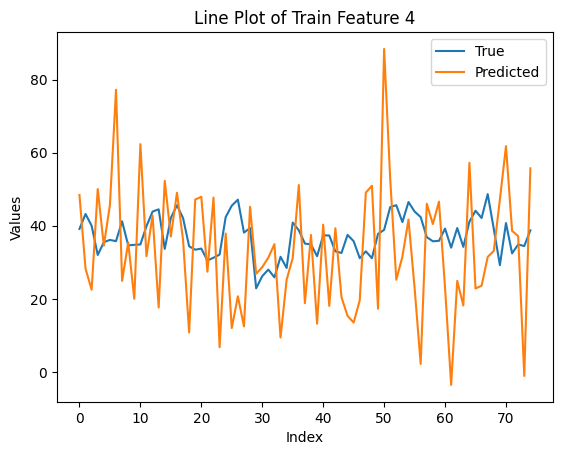

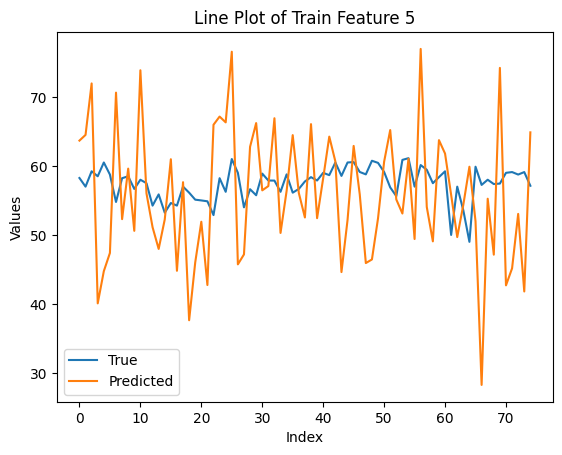

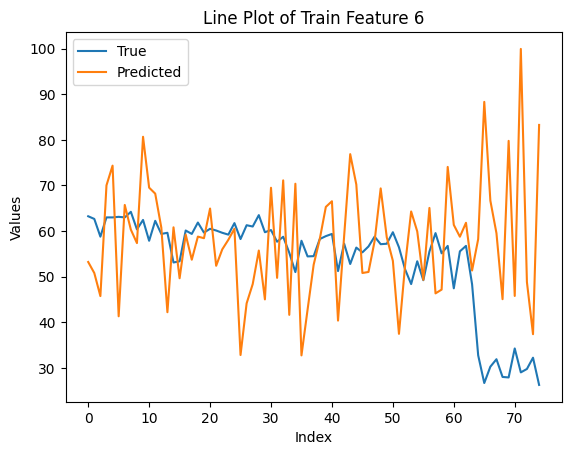

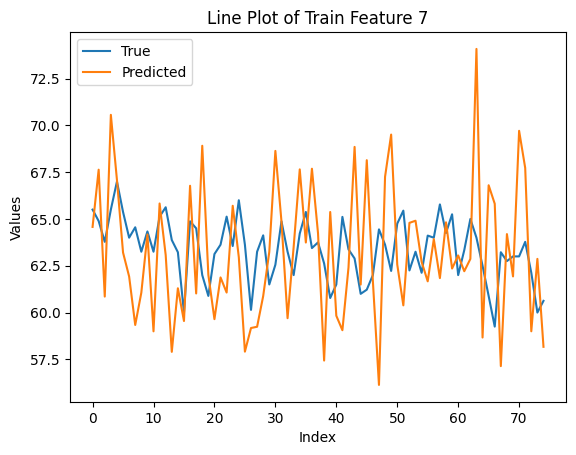

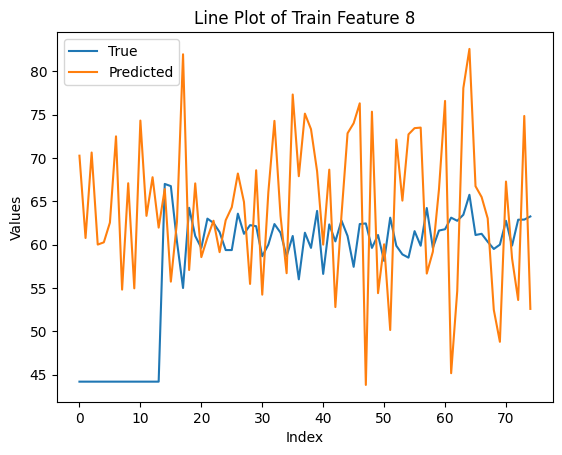

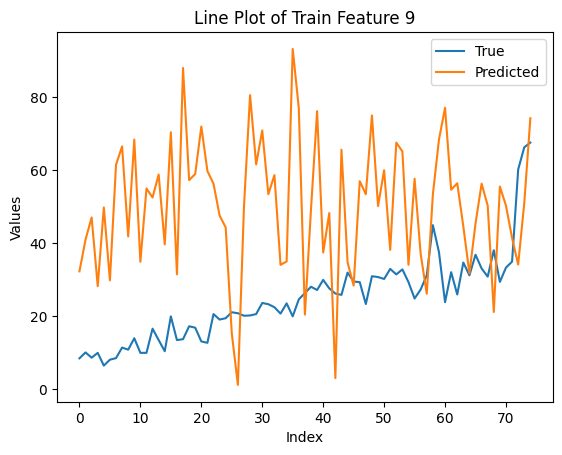

<Figure size 640x480 with 0 Axes>

In [13]:
SPLIT_NAME = 'Train'

# output = denormalize(model.predict_step(train_data, start=0, steps=50, mode='sum'))
output = model.predict_step(train_data, start=25, steps=75, mode='mean')

# data_true = denormalize(train_label[0:50, :, :].numpy())
data_true = train_label[25:100, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='MetrLA')
data_predicted = denormalize(data_predicted, name='MetrLA')
for i in range(10):
    first_elements_arr1 = [subarr[i] for subarr in data_true]
    first_elements_arr2 = [subarr[i] for subarr in data_predicted]
    # Plotting
    plt.plot(first_elements_arr1, label='True')
    plt.plot(first_elements_arr2, label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Line Plot of Train Feature {i}')
    plt.legend()
    plt.show()
    plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}.png')
    plt.clf()

## Generate on Train

100%|██████████| 75/75 [00:00<00:00, 96.59it/s]


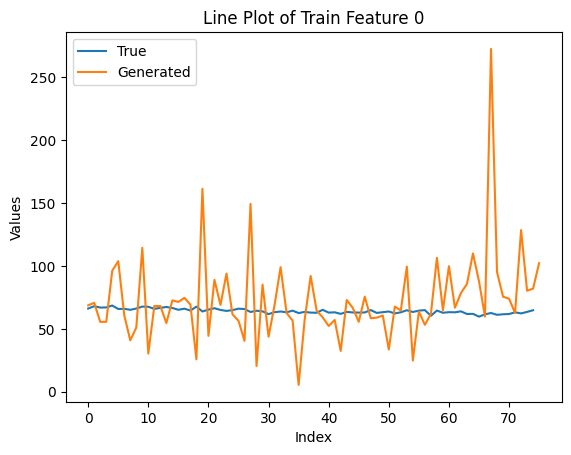

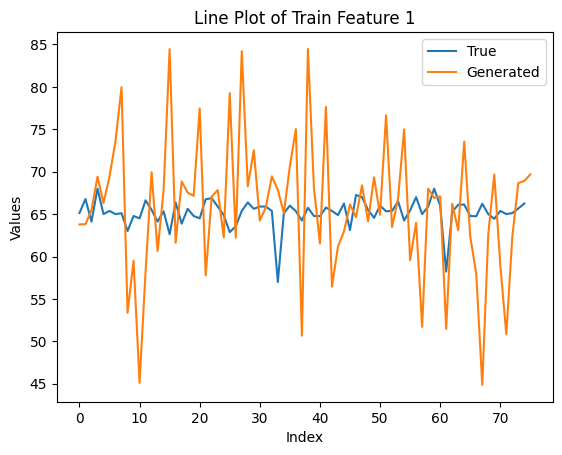

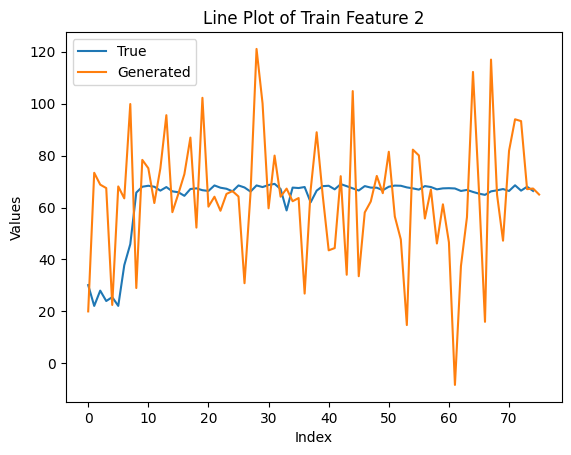

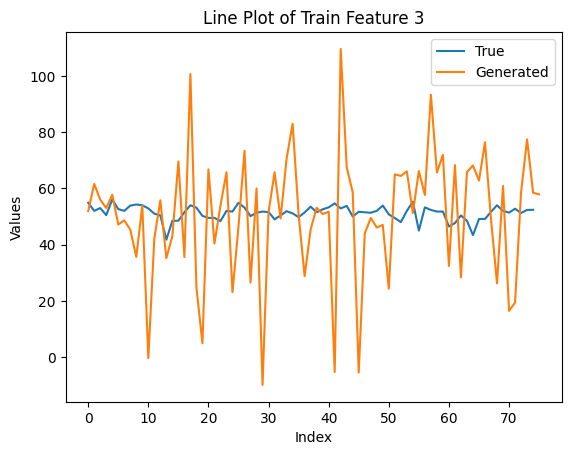

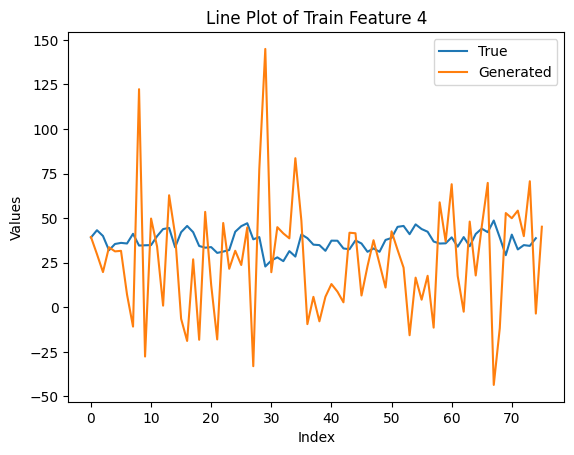

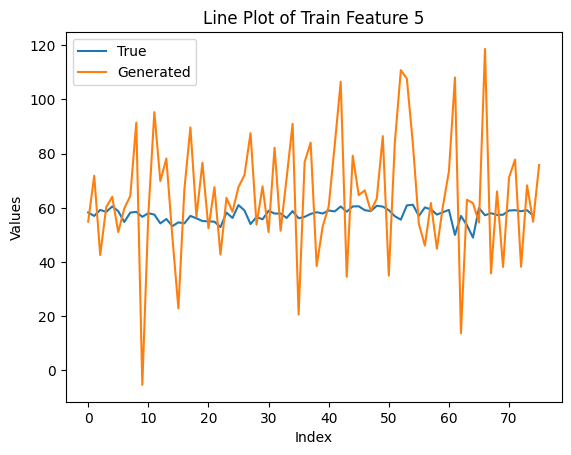

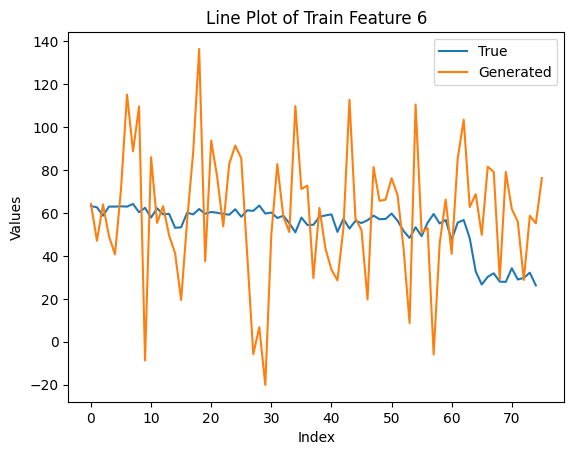

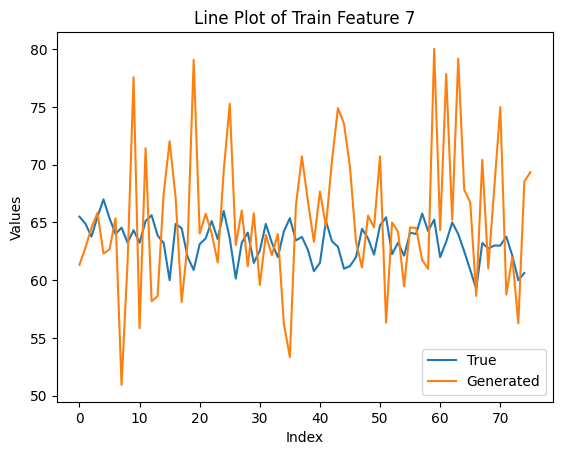

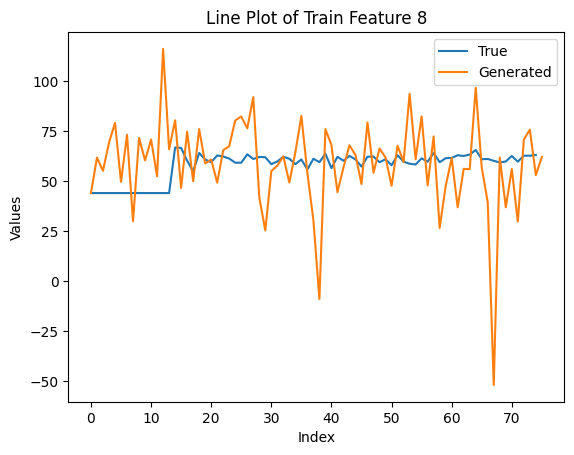

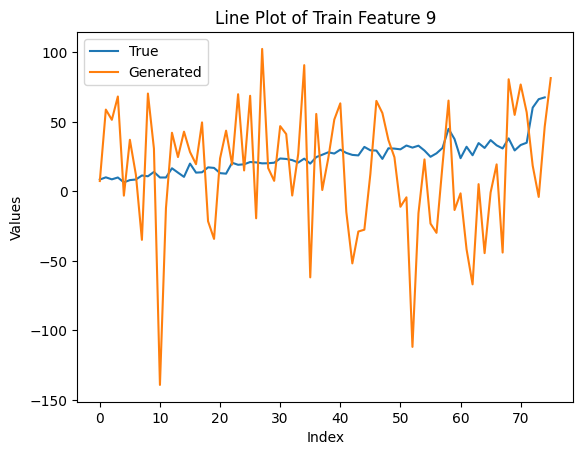

<Figure size 640x480 with 0 Axes>

In [14]:
# output = denormalize(model.generate_step(train_data, start=0, steps=200, mode='mean'))
output = model.generate_step(train_data, start=25, steps=75, mode='mean')

# data_true = denormalize(train_label[0:200, :, :].numpy())
data_true = train_label[25:100, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='MetrLA')
data_predicted = denormalize(data_predicted, name='MetrLA')
for i in range(10):
    first_elements_arr1 = [subarr[i] for subarr in data_true]
    first_elements_arr2 = [subarr[i] for subarr in data_predicted]
    # Plotting
    plt.plot(first_elements_arr1, label='True')
    plt.plot(first_elements_arr2, label='Generated')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Line Plot of Train Feature {i}')
    plt.legend()
    plt.show()
    plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}_GEN.png')
    plt.clf()

In [15]:

print(mmd_linear(data_true, data_predicted))  # 6.0
print(mmd_rbf(data_true, data_predicted))  # 0.5822
print(mmd_poly(data_true, data_predicted))  # 2436.5

32190.662
0.026491228491067886
43305664512.0
